In [6]:
#Importing Libraries
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
import tensorflow as tf
import keras_metrics

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn import svm, datasets
from sklearn import metrics
from sklearn import preprocessing
import datetime as dt
import urllib.request, json
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


(67066, 1, 16) (67066,) (2760, 1, 16) (2760,)
Train on 67066 samples, validate on 2760 samples
Epoch 1/20
67066/67066 [==============================] - 2s 27us/step - loss: 0.0289 - val_loss: 0.0339
Epoch 2/20
67066/67066 [==============================] - 1s 12us/step - loss: 0.0226 - val_loss: 0.0327
Epoch 3/20
67066/67066 [==============================] - 1s 12us/step - loss: 0.0222 - val_loss: 0.0321
Epoch 4/20
67066/67066 [==============================] - 1s 12us/step - loss: 0.0220 - val_loss: 0.0326
Epoch 5/20
67066/67066 [==============================] - 1s 12us/step - loss: 0.0218 - val_loss: 0.0321
Epoch 6/20
67066/67066 [==============================] - 1s 12us/step - loss: 0.0217 - val_loss: 0.0322
Epoch 7/20
67066/67066 [==============================] - 1s 12us/step - loss: 0.0217 - val_loss: 0.0328
Epoch 8/20
67066/67066 [==============================] - 1s 12us/step - loss: 0.0216 - val_loss: 0.0325
Epoch 9/20
67066/67066 [==============================] - 1s 12us

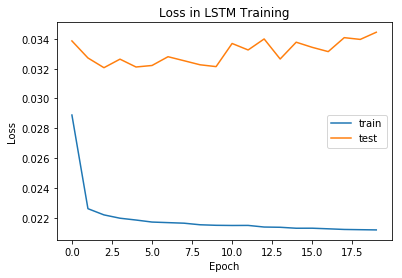

2760/2760 [==============================] - 0s 4us/step
Test score:  0.03444463640815862
['loss']


In [21]:
# load dataset
dataset = read_csv('PatientDataAll.csv', header=0, index_col=0)
values = dataset.values
values[:,4]

#Load test dataset
test_dataset = read_csv('PatientData591test.csv', header = 0, index_col = 0)
test_values = test_dataset.values
test_values[:,4]

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
test_values[:,4] = encoder.fit_transform(test_values[:,4])
# ensure all data is float
values = values.astype('float32')
test_values = test_values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
test_scaled = scaler.fit_transform(test_values)

# train the training set and test the testing set
values = scaled
test_values = test_scaled

train=scaled
test=test_scaled

# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')

# fit network
history = model.fit(train_X, train_y, epochs= 20, batch_size=256, validation_data=(test_X, test_y))#  , verbose=2, shuffle=False)
#history = model.fit(train_X, train_y, epochs= 5, batch_size=256)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss in LSTM Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#test for fitting type of model
score = model.evaluate(test_X, test_y, batch_size=258)
names = model.metrics_names
print('Test score: ',score)
print(names)

In [22]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = concatenate((yhat, test_X), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat1[:,0]

# invert scaling for actual

test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat1))
rmse

46.026982893699156

In [23]:
inv_yhat1

array([144.98639 , 145.28268 , 145.40266 , ..., 179.52058 , 172.50136 ,
       117.294334], dtype=float32)

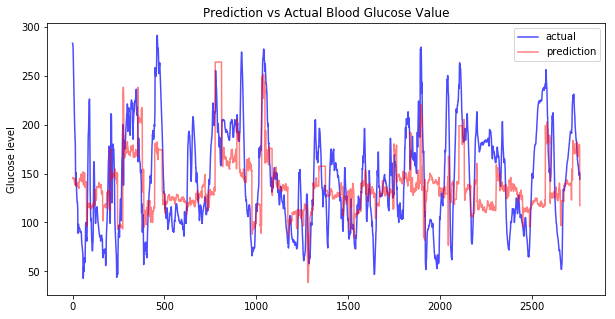

In [24]:
plt.figure(figsize=(10,5))
plt.plot(inv_y, color ='blue', alpha = 0.7,label = "actual")
plt.plot(inv_yhat1,color='red',alpha = 0.5, label = "prediction")
plt.legend()
plt.ylabel("Glucose level")
plt.title("Prediction vs Actual Blood Glucose Value")
plt.show()